## **VISIUM-Based Spatial Transcriptomics Data Analysis of the Human Brain**
---

This notebook implements a step-by-step analysis pipeline for the 10x Genomics Visium dataset ([dataset link](https://www.10xgenomics.com/datasets/gene-and-protein-expression-library-of-human-glioblastoma-cytassist-ffpe-2-standard)) from Human Glioblastoma. Any Visium 2.1.0 dataset  can be loaded and analyzed similarly.


##  **Environment Setup for SpatialData Installation (Colab)**
---

SpatialData requires specific versions of `dask` and related packages which may conflict with the default versions in Kaggle or Google Colab. This section ensures the correct environment setup by uninstalling the conflicting packages and installing the required versions.

> **Note**: You will need to **restart the session** after these steps to apply the changes (in Colab: `Runtime` > `Restart session`).

We also need to install spatialdata-io for datasets which need to be transformed in spatialdata prescribed format using spatialdata-sandbox as shown below.

In [1]:
# Step 1: Uninstall conflicting versions of dask-related packages (default versions in Colab/Kaggle)
!pip uninstall -y dask distributed dask-expr rapids-dask-dependency


Found existing installation: dask 2024.12.1
Uninstalling dask-2024.12.1:
  Successfully uninstalled dask-2024.12.1
Found existing installation: distributed 2024.12.1
Uninstalling distributed-2024.12.1:
  Successfully uninstalled distributed-2024.12.1
Found existing installation: dask-expr 1.1.21
Uninstalling dask-expr-1.1.21:
  Successfully uninstalled dask-expr-1.1.21
Found existing installation: rapids-dask-dependency 25.2.0
Uninstalling rapids-dask-dependency-25.2.0:
  Successfully uninstalled rapids-dask-dependency-25.2.0


In [ ]:
# Step 2: Install versions compatible with SpatialData
!pip install dask==2024.12.1 distributed==2024.12.1 dask-expr==1.1.21 rapids-dask-dependency==25.2.0


In [ ]:
# Step 3: Restart session

In [ ]:
# Step 4: Install SpatialData after setting up the required environment
!pip install spatialdata


In [ ]:
# Step 5: Restart session

In [1]:
# Step 6: Check if spatialdata is correctly installed and confirm its version
import spatialdata
print(spatialdata.__version__)


/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


0.4.0


In [ ]:
# Step 7: spatialdata-io is required to handle spatial transcriptomics datasets that are not already in the standardized spatialdata format.
# Such datasets must first be processed through spatialdata-sandbox to ensure compatibility with the spatialdata framework.
!pip install spatialdata-io


In [ ]:
# Step 8: Restart session

In [ ]:
# Step 9: Check if spatialdata-io is correctly installed and confirm its version
!pip show spatialdata-io


## **Configuration – Set Parameters for Data & Output Paths**

In [35]:
# ====== PARAMETERS / CONFIGURATION ======

# Paths for storing data and outputs
ALL_GENES_CSV = "/content/all_genes.csv"
CANDIDATE_GENE_LIST_PATH = "/content/candidate_genes.csv"
GENE_PLOTS_DIR = "/content/gene_plots/"
SCATTER_PLOT_PATH = "/content/scatter_plot.png"
JOINT_EXPR_CSV = "/content/joint_expression_scores.csv"
JOINT_EXPR_PLOT_PATH = "/content/joint_expression_heatmap.png"


# Other parameters
SCATTER_POINT_SIZE = 7
SCATTER_ALPHA = 0.8

# Gene for single gene expression visualization example
EXAMPLE_GENE = "B3GALT6"
EXAMPLE_GENE_HEATMAP = "/content/gene_plots/B3GALT6_heatmap.png"

## **Importing Necessary Libraries**

In [3]:
import zipfile
import os
from spatialdata import SpatialData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


# 📁Data Loading

---

We now download and extract the 10x Genomics Visium dataset. This dataset captures molecular and spatial information from human brain region.

In [4]:
# Source: https://github.com/giovp/spatialdata-sandbox/blob/main/utils.py

import os
import subprocess
import urllib.request
import zipfile
from typing import Callable, Any
from spatialdata import SpatialData
from pathlib import Path
import shutil

from tqdm import tqdm


class TqdmDownload(tqdm):
    def __init__(self, *args, **kwargs):
        kwargs = dict(kwargs)
        kwargs.update({"unit": "B", "unit_scale": True, "unit_divisor": 1024})
        super().__init__(*args, **kwargs)

    def update_to(self, nblocks=1, blocksize=1, total=-1):
        self.total = total
        self.update(nblocks * blocksize - self.n)


def is_aria2c_installed():
    rc = subprocess.call(["which", "aria2c"])
    if rc == 0:
        return True
    else:
        return False


def download(url, outfile, desc):
    # aria2c (maybe) is faster than urllib
    if not is_aria2c_installed() or True:
        subprocess.check_call(
            [
                "curl",
                "-o",
                outfile,
                url,
            ]
        )
    else:
        subprocess.check_call(
            [
                "aria2c",
                "--allow-overwrite",
                "-x",
                "4",
                "--dir",
                os.path.dirname(outfile),
                "-o",
                os.path.basename(outfile),
                url,
            ]
        )


def unzip(file, outdir=None, files=None, rm=True):
    if outdir is None:
        outdir = os.getcwd()
    else:
        os.makedirs(outdir, exist_ok=True)
    zfile = zipfile.ZipFile(file)
    if files is not None:
        for f in files:
            zfile.extract(f, outdir)
    else:
        zfile.extractall(outdir)
    zfile.close()
    if rm:
        os.unlink(file)

In [5]:
# Source: https://github.com/giovp/spatialdata-sandbox/blob/main/visium_2.1.0_2_io/download.py

import os
import subprocess
from pathlib import Path
import sys

# Add current directory to sys.path
sys.path.insert(1, os.getcwd())


# Download URLs from 10x Genomics
urls = [
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_tissue_image.tif",
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_image.tif",
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_alignment_file.json",
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_molecule_info.h5",
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_filtered_feature_bc_matrix.h5",
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz",
]

# Create data directory
os.makedirs("data", exist_ok=True)

# Download files
for url in urls:
    print("Downloading:", url)
    name = Path(url).name
    download(url, os.path.join("data", name), name)

# Extract spatial data
subprocess.run("tar -xzf data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz -C data", shell=True, check=True)
subprocess.run("rm data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz", shell=True, check=True)


Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_tissue_image.tif
Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_image.tif
Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_alignment_file.json
Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_molecule_info.h5
Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_filtered_feature_bc_matrix.h5
Downloading: https://cf.10xgenomics.com/sample

CompletedProcess(args='rm data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz', returncode=0)

In [ ]:
# Source: https://github.com/giovp/spatialdata-sandbox/blob/main/visium_2.1.0_2_io/to_zarr.py
# ----------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------
# ---------------------------------- spatialdata-sandbox ---------------------------------------------------
# ----------------------------------------------------------------------------------------------------------

from spatialdata_io import visium
import spatialdata as sd
##
from pathlib import Path
import shutil

##
path = Path().resolve()
# luca's workaround for pycharm
path_read = path / "data"
path_write = path / "data.zarr"
##
sdata = visium(path_read, fullres_image_file="CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_tissue_image.tif")
##
if path_write.exists():
    shutil.rmtree(path_write)
sdata.write(path_write)
print("done")
##
print(f'view with "python -m napari_spatialdata view data.zarr"')
sdata = sd.SpatialData.read(path_write)
print(sdata)
print("read")


In [7]:
# As you know the .zarr folder name exactly (e.g., visium.zarr or data.zarr), define the path
zarr_path = '/content/data.zarr'  # adjust if folder name is different
print("Zarr folder path:", zarr_path)


Zarr folder path: /content/data.zarr


In [ ]:
from spatialdata import SpatialData

# Read the SpatialData object
sdata = SpatialData.read(zarr_path)
print(sdata)


# **Dataset Structure Exploration**
---

After loading the dataset, we inspect the structure of the `SpatialData` object. This helps us understand the types of spatial and tabular information available, including images, labels, shapes, and cell-level metadata stored in the `AnnData` table.


In [9]:
# View available image keys in the spatial dataset
print("Images:", list(sdata.images.keys()))

# View available label (segmentation or annotation) keys
print("Labels:", list(sdata.labels.keys()))

# View geometric shape annotations if any are present
print("Shapes:", list(sdata.shapes.keys()))

# Confirm the type of the underlying table storing observations
print("Table object type:", type(sdata.table))

# Check the size of the AnnData object (cells × features)
print("AnnData shape:", sdata.table.shape)

# Preview the first few rows of the observations (cell metadata)
print("Table Preview:")
print(sdata.table.obs.head())

Images: ['CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_full_image', 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image', 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image']
Labels: []
Shapes: ['CytAssist_FFPE_Protein_Expression_Human_Glioblastoma']
Table object type: <class 'anndata._core.anndata.AnnData'>
AnnData shape: (5756, 18085)
Table Preview:
                    in_tissue  array_row  array_col  spot_id  \
AACAATGGAACCACAT-1          1         54         32        0   
AACAATGTGCTCCGAG-1          1         98        158        1   
AACACCAGCCTACTCG-1          1         31         39        2   
AACACCATTCGCATAC-1          1         53        139        3   
AACACCGAATGTCTCA-1          1         34        176        4   

                                                               region  
AACAATGGAACCACAT-1  CytAssist_FFPE_Protein_Expression_Human_Gliobl...  
AACAATGTGCTCCGAG-1  CytAssist_FFPE_Protein_Expression_Human_Gliobl...  
AACACCA

# **Essential Dataset Tools**
---

In the following sections, we extract and save useful metadata from the dataset for external inspection or visualization or even downstream analysis.





## **Save All Gene Names to CSV**  

---

  Extract all gene names from the spatial transcriptomics dataset and save them in a CSV file. This allows for easy access when performing gene filtering, ranking, or downstream selection.

In [10]:
import pandas as pd

# Save gene names from the AnnData inside SpatialData
gene_names = sdata.table.var_names.to_list()
gene_df = pd.DataFrame({"gene": gene_names})
gene_df.to_csv(ALL_GENES_CSV, index=False)

print(f"Saved {len(gene_names)} gene names to {ALL_GENES_CSV}")

Saved 18085 gene names to /content/all_genes.csv


## **Checking Spatial Geometry and Coordinate Dimensionality**

---

This code verifies the spatial data’s geometric structure prints the coordinate dimensionality to confirm whether the dataset represents 2D or 3D spatial data.

This check is important for choosing appropriate visualization and analysis methods based on spatial complexity.

In [14]:
print(sdata.shapes.keys())

dict_keys(['CytAssist_FFPE_Protein_Expression_Human_Glioblastoma'])


In [37]:
# Automatically select the first available shape layer
shape_layer_name = list(sdata.shapes.keys())[0]
print(shape_layer_name)

CytAssist_FFPE_Protein_Expression_Human_Glioblastoma


In [38]:
# Checking if dataset is 2D or 3D
geometry = sdata.shapes[shape_layer_name]['geometry']
assert all(geometry.geom_type == 'Point'), "Non-point geometries found!"
coords_dim = geometry.apply(lambda g: len(g.coords[0])).unique()
print(f"Coordinate dimensionality: {coords_dim}")


Coordinate dimensionality: [2]


## **Visualizing Spatial Positions of Cells**
---
This subsection plots all detected cells (spots) in their spatial coordinates using a scatter plot.  
Each dot represents a single cell’s position within the tissue section.

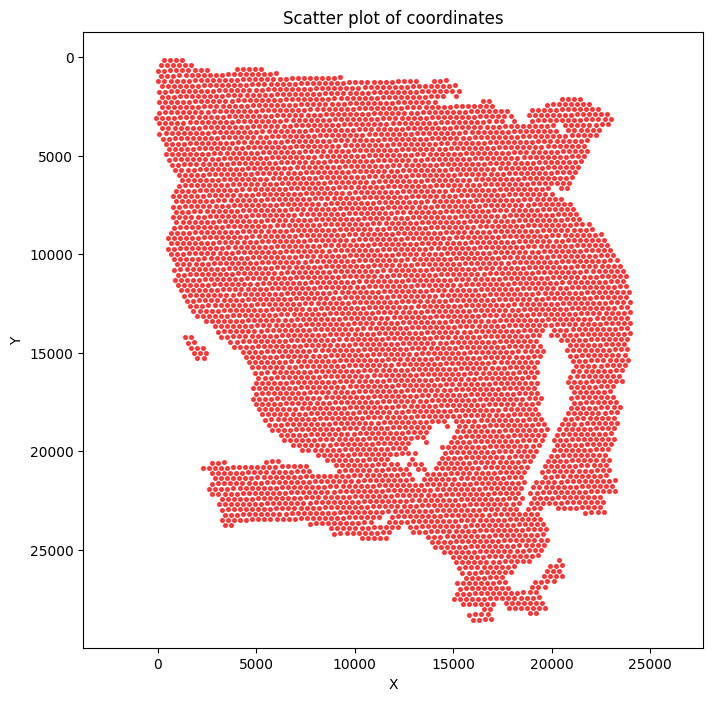

In [17]:
import matplotlib.pyplot as plt

# Step 1: Extract the coordinates
coords = sdata.table.obsm["spatial"]  # shape: (n_spots, 2), columns = x, y

# Step 2: Plot the coordinates
plt.figure(figsize=(8, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=SCATTER_POINT_SIZE, alpha=SCATTER_ALPHA, c='red')
plt.title("Scatter plot of coordinates")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()  # Optional: flip to match image orientation
plt.grid(False)
plt.axis("equal")
plt.savefig(SCATTER_PLOT_PATH, dpi=300, bbox_inches='tight')
plt.show()


## **Visualizing Single Gene Expression Heatmap**

This section defines a function to visualize the spatial expression pattern of any selected gene across the tissue section. An example is provided for the gene **“Asic4”**, and the output plot is saved in the folder `/content/gene_plots/`.

In [43]:
def plot_gene_expression_heatmap(sdata, gene_name, output_path=None):
    # Get the AnnData table (assuming there's only one, e.g., 'table')
    table = list(sdata.tables.values())[0]

    # Check if gene exists
    if gene_name not in table.var_names:
        print(f"Gene '{gene_name}' not found in dataset.")
        return

    # Get expression values
    gene_index = table.var_names.get_loc(gene_name)
    X = table.X
    if hasattr(X, "toarray"):  # If sparse, convert to dense
        expression_values = X[:, gene_index].toarray().flatten()
    else:  # Already dense
        expression_values = X[:, gene_index].flatten()

    # Get cell coordinates
    geometry = sdata.shapes[shape_layer_name]['geometry']
    x = geometry.x
    y = geometry.y

    # Plot
    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(x, y, c=expression_values, cmap='viridis', s=SCATTER_POINT_SIZE, alpha=SCATTER_ALPHA)
    plt.colorbar(scatter, label=f"{gene_name} expression")
    plt.title(f"Expression Heatmap: {gene_name}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


In [44]:
# Create directory if it doesn't exist
os.makedirs(GENE_PLOTS_DIR, exist_ok=True)


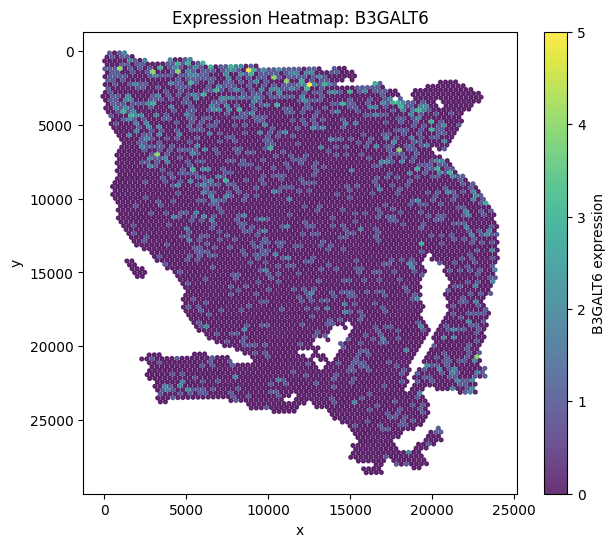

In [45]:
plot_gene_expression_heatmap(sdata, EXAMPLE_GENE, EXAMPLE_GENE_HEATMAP)


## 🔗 **Joint Expression Analysis & Module Score Visualization**

This section performs a combined expression analysis for a set of candidate genes, providing insights into their collective activity across the tissue.

- The candidate genes are loaded from a CSV file (`candidate_genes.csv`), which contains a list of genes of interest.
- The function **`compute_joint_expression`** filters these genes to keep only those present in the dataset.
- It computes a **joint expression score** for each cell by averaging the expression values of the valid candidate genes, representing a module score.
- Spatial coordinates of each cell are extracted from the dataset.
- The joint expression scores, along with the spatial coordinates, are saved to a CSV file for further analysis.
- The function **`plot_joint_expression`** visualizes this combined score as a heatmap across the tissue.
- This approach helps identify spatial patterns of gene modules or pathways, offering biological insights beyond single-gene analysis.

The resulting heatmap plot is saved as `joint_expression_heatmap.png`.


In [26]:
# Load candidate gene list (one gene per line, no header)
candidate_genes = pd.read_csv(CANDIDATE_GENE_LIST_PATH, header=None)[0].tolist()
print(f"Loaded {len(candidate_genes)} genes.")

Loaded 34 genes.


In [39]:
def compute_joint_expression(sdata, gene_list):
    # Get the table (assumes single table)
    table = list(sdata.tables.values())[0]

    # Filter only genes present in the dataset
    valid_genes = [g for g in gene_list if g in table.var_names]
    if not valid_genes:
        raise ValueError("None of the genes are found in the dataset.")
    print(f"{len(valid_genes)} valid genes found in the dataset.")

    # Extract expression matrix and coordinates
    X = table[:, valid_genes].X
    if hasattr(X, "toarray"):
        X = X.toarray()

    joint_score = X.mean(axis=1)  # average expression per cell

    # Coordinates
    geometry = sdata.shapes[shape_layer_name]['geometry']
    x = geometry.x.values
    y = geometry.y.values

    return pd.DataFrame({"x": x, "y": y, "joint_score": joint_score})

In [40]:
joint_df = compute_joint_expression(sdata, candidate_genes)
joint_df.to_csv(JOINT_EXPR_CSV, index=False)
print("Saved joint scores with coordinates to joint_expression_scores.csv")

34 valid genes found in the dataset.
Saved joint scores with coordinates to joint_expression_scores.csv


In [41]:
def plot_joint_expression(joint_df, title="Joint Expression Heatmap", output_path=None):
    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(joint_df["x"], joint_df["y"],
                          c=joint_df["joint_score"], cmap='plasma', s=SCATTER_POINT_SIZE, alpha=SCATTER_ALPHA)
    plt.colorbar(scatter, label="Joint Expression Score")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

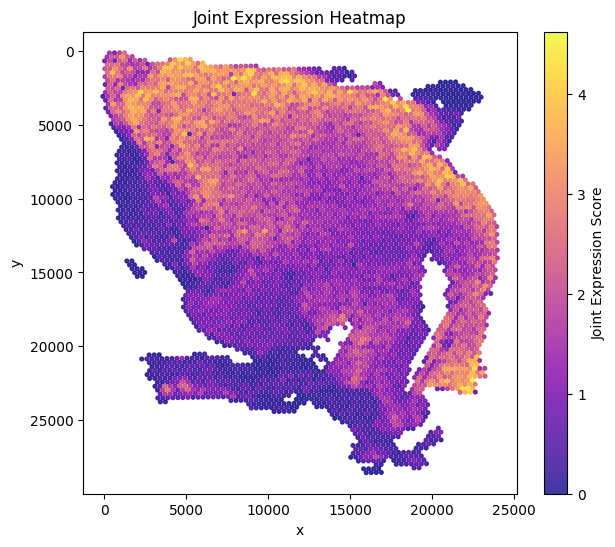

In [42]:
plot_joint_expression(joint_df, output_path=JOINT_EXPR_PLOT_PATH)